### import the required libraries

In [169]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


### let's load the data

In [170]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

### all the relevant needed data is in the *features* key  
### let's define a new variable that includes this data

In [171]:
neighborhoods_data = newyork_data['features']

In [172]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### transforming this data of nested python dictionaries into a *pandas* dataframe

In [173]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

### let's loop through the data and fill the dataframe one row at a time

In [174]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

### quickly examine the resulting dataframe

In [175]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### check the number of borough and neighborhoods

In [176]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### let's check the count of neighborhoods for each of the 5 boroughs

In [177]:
#neighborhoods[neighborhoods['Neighborhood']=='Bay Terrace']
neighborhoods.groupby('Borough').count().reset_index()[['Borough','Neighborhood']]

,Borough,Neighborhood
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


### use geopy library to get the latitude and longitude values of New York City

In [178]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


### let's create a map of New York with neighborhoods superimposed on top.

In [179]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### define Foursquare Credentials and Version

In [180]:
CLIENT_ID = '4YJHMILMGX02K4KWNARJBMIMXF3ZXSPEKNT5T44JKSSMPZWS' # your Foursquare ID
CLIENT_SECRET = 'XS3VETLVJANNSN2KTEN4FQYHLE3ECEPET1WJMLB4HSN0BFNQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4YJHMILMGX02K4KWNARJBMIMXF3ZXSPEKNT5T44JKSSMPZWS
CLIENT_SECRET:XS3VETLVJANNSN2KTEN4FQYHLE3ECEPET1WJMLB4HSN0BFNQ


### let's create a function to search for restaurant in a radius of 500 meters for each of the neighborhood

In [181]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
search_query = 'restaurant|Restaurant'

def getNearbyVenues(boroughs, names, latitudes, longitudes):
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name','location.lat','location.lng','categories','location.distance']
    # create an empty dataframe
    nearby_venues=pd.DataFrame(columns=['Borough','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category','Venue Distance'])

    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            search_query,
            radius,
            LIMIT)

        results = requests.get(url).json()
        
        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # tranform venues into a dataframe
        dataframe = json_normalize(venues)
        
        if dataframe.shape[0]==0:
            continue

        # keep only columns that include venue name, and anything that is associated with location
        dataframe_filtered = dataframe.loc[:][filtered_columns]
        
        # function that extracts the category of the venue
        def get_category_type(row):
            categories_list = row['categories'] 
            if len(categories_list) == 0:
                return None
            else:
                return categories_list[0]['name']

        # filter the category for each row
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        
        for i in range(dataframe_filtered.shape[0]):
            nearby_venues=nearby_venues.append({'Borough':borough,
                                                'Neighborhood':name,
                                                'Neighborhood Latitude':lat,
                                                'Neighborhood Longitude':lng,
                                                'Venue' : dataframe_filtered.iloc[i]['name'],
                                                'Venue Latitude': dataframe_filtered.iloc[i]['location.lat'],
                                                'Venue Longitude': dataframe_filtered.iloc[i]['location.lng'],
                                                'Venue Category': dataframe_filtered.iloc[i]['categories'],
                                                'Venue Distance': dataframe_filtered.iloc[i]['location.distance']
                                               },ignore_index=True)
    
    return(nearby_venues)

### code to run the above function on each neighborhood and create a new dataframe called *new_york_venues*

In [182]:
new_york_venues = getNearbyVenues(boroughs=neighborhoods.loc[:]['Borough'],
                                  names=neighborhoods.loc[:]['Neighborhood'],
                                  latitudes=neighborhoods.loc[:]['Latitude'],
                                  longitudes=neighborhoods.loc[:]['Longitude']
                                  )

### lets take a backup of the created dataframe and save it as *new_york_venues_df.pkl*

In [183]:
new_york_venues.to_pickle('new_york_venues_df.pkl')

### when needed data can be loaded back from file *new_york_venues_df.pkl*

In [184]:
new_york_venues = pd.read_pickle('new_york_venues_df.pkl')
new_york_venues.shape

(4195, 9)

### get first 5 records of the dataframe

In [210]:
new_york_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Bronx,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant,479
1,Bronx,Wakefield,40.894705,-73.847201,Cool Running Restaurant,40.898130,-73.848516,Food,396
2,Bronx,Wakefield,40.894705,-73.847201,Bay restaurant,40.890850,-73.848860,None,451
3,Bronx,Wakefield,40.894705,-73.847201,Fort Negril Jamaican Restaurant,40.898318,-73.850442,Food,485
4,Bronx,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,40.876603,-73.829710,Chinese Restaurant,257


### let's get the borough for which no reastaurant found in a radius of 500 meters

In [189]:
neighborhoods_no_restaurants= neighborhoods[(neighborhoods['Neighborhood'].isin(new_york_venues['Neighborhood']) == False)
                                            & (neighborhoods['Borough'].isin(new_york_venues['Borough']) == True)].reset_index(drop=True)
neighborhoods_no_restaurants[neighborhoods_no_restaurants['Borough']=='Queens'].reset_index(drop=True)

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Whitestone,40.781291,-73.814202
1,Queens,Broad Channel,40.603027,-73.820055
2,Queens,Breezy Point,40.557401,-73.925512
3,Queens,Rockaway Beach,40.582802,-73.822361
4,Queens,Neponsit,40.572037,-73.857547
5,Queens,Belle Harbor,40.576156,-73.854018
6,Queens,Somerville,40.597711,-73.796648
7,Queens,Utopia,40.733500,-73.796717
8,Queens,Roxbury,40.567376,-73.892138
9,Queens,Bayswater,40.611322,-73.765968


In [190]:
neighborhoods_no_restaurants.groupby('Borough').count().reset_index()[['Borough','Neighborhood']].sort_values(
    'Neighborhood',ascending=False).reset_index(drop=True).rename(columns={'Neighborhood': 'Count: Neighborhoods having no Restaurant identified'})

,Borough,Count: Neighborhoods having no Restaurant identified
0,Staten Island,20
1,Queens,10
2,Bronx,3
3,Brooklyn,3
4,Manhattan,1


### let's visualize this with the help of a bar graph

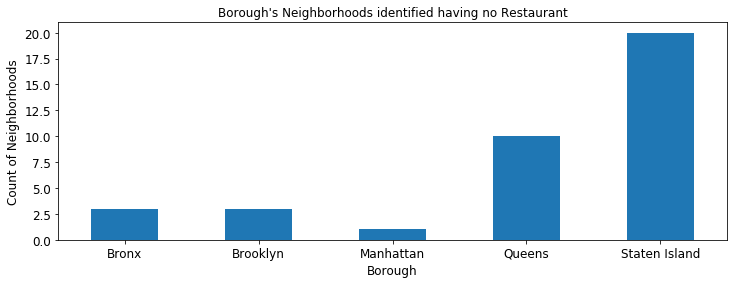

In [191]:
df=neighborhoods_no_restaurants.groupby('Borough').count().reset_index()[['Borough','Neighborhood']]
ax =df.plot(kind='bar', title ="Borough's Neighborhoods identified having no Restaurant", figsize=(12, 4), legend=False, fontsize=12)
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Count of Neighborhoods", fontsize=12)
ax.set_xticklabels(df['Borough'], rotation=0)
plt.show()

### let's recall the findings done till as of now

In [192]:
new_york_summarize = neighborhoods.groupby('Borough').count().reset_index()[['Borough','Neighborhood']]
new_york_summarize['Venue'] = new_york_venues.groupby('Borough').count().reset_index()['Venue']
new_york_summarize['Neighborhood Having No Restaurant'] = neighborhoods_no_restaurants.groupby('Borough').count().reset_index()[['Neighborhood']]
new_york_summarize.columns=['Borough','Total Number of Neighborhoods','Total Number of Restaurants','Neighborhoods Having No Restaurant']
new_york_summarize

,Borough,Total Number of Neighborhoods,Total Number of Restaurants,Neighborhoods Having No Restaurant
0,Bronx,52,715,3
1,Brooklyn,70,938,3
2,Manhattan,40,1560,1
3,Queens,81,819,10
4,Staten Island,63,163,20


### *Staten Island* and *Queens* has quite a good number of neighborhoods having no restaurant identified  
### we will take *Queens* for our further analysis and skip *Staten Island*
### one of the reason for this is that *Queens* has highest number of neighborhoods(81)
### let's fetch the neighborhoods for *Queens*

In [193]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


### let's create a function to explore all the neighborhoods for borough *Queens*

In [194]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
      #  print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   # print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### code to run the above function on each neighborhood and create a new dataframe called *queens_venues*

In [195]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

### lets take a backup of the created dataframe and save it as *queens_venues_df.pkl*

In [196]:
queens_venues.to_pickle('queens_venues_df.pkl')

### when needed data can be loaded back from file *queens_venues_df.pkl*

In [197]:
queens_venues = pd.read_pickle('queens_venues_df.pkl')
queens_venues.shape

(2099, 7)

### lets check first 5 records

In [207]:
queens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant


### as we are interested in locating a restaurant, irrespective of its type, we will replace restaurant's type with keyword *Restaurant* for column *Venue Category*

In [225]:
queens_venues_modified = queens_venues.copy()

for i in range(queens_venues_modified.shape[0]):
    if ('Restaurant' in queens_venues_modified.loc[i,'Venue Category'] 
        or 'restaurant' in queens_venues_modified.loc[i,'Venue Category']
        or 'Restaurant' in queens_venues_modified.loc[i,'Venue']
        or 'restaurant' in queens_venues_modified.loc[i,'Venue']
       ):
            queens_venues_modified.loc[i,'Venue Category']='Restaurant'

queens_venues_modified.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Restaurant


### let's find out how many unique categories can be curated from all the returned venues

In [216]:
print('There are {} uniques categories.'.format(len(queens_venues_modified['Venue Category'].unique())))

There are 206 uniques categories.


### let's convert categorical column *Venue Category* into numerical

In [217]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues_modified[['Venue Category']])#, prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues_modified['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport Terminal,Venue Category_Antique Shop,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Arts & Entertainment,Venue Category_Athletics & Sports,Venue Category_Automotive Shop,...,Venue Category_Vape Store,Venue Category_Video Game Store,Venue Category_Video Store,Venue Category_Warehouse Store,Venue Category_Weight Loss Center,Venue Category_Wine Bar,Venue Category_Wine Shop,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [218]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped.head()

,Neighborhood,Venue Category_Accessories Store,Venue Category_Airport Terminal,Venue Category_Antique Shop,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Arts & Entertainment,Venue Category_Athletics & Sports,Venue Category_Automotive Shop,...,Venue Category_Vape Store,Venue Category_Video Game Store,Venue Category_Video Store,Venue Category_Warehouse Store,Venue Category_Weight Loss Center,Venue Category_Wine Bar,Venue Category_Wine Shop,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Arverne,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00,0.0,0.000000,0.0
1,Astoria,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.0,0.01,0.0,0.000000,0.0
2,Astoria Heights,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00,0.0,0.000000,0.0
3,Auburndale,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00,0.0,0.000000,0.0
4,Bay Terrace,0.02439,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.02439,0.0,0.0,0.02439,0.0,0.00,0.0,0.073171,0.0


In [203]:
queens_grouped.shape

(81, 207)

### let's write a function to sort the venues in descending order

In [252]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### let's create the new dataframe and display the top 10 venues for each neighborhood

In [271]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
queens_venues_sorted = pd.DataFrame(columns=columns)
queens_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

queens_venues_sorted_frequency = queens_venues_sorted.copy()

for ind in np.arange(queens_grouped.shape[0]):
    queens_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)
    queens_venues_sorted_frequency.iloc[ind, 1:] = queens_grouped.iloc[0, :].iloc[1:].sort_values(ascending=False)[0:num_top_venues].values

queens_venues_sorted = queens_venues_sorted.applymap(lambda x: str(x).replace('Venue Category_',''))
queens_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Playground,Restaurant,Board Shop,Bed & Breakfast,Bus Stop,Beach,Sandwich Place,Donut Shop
1,Astoria,Restaurant,Bar,Hookah Bar,Bakery,Pub,Ice Cream Shop,Food Truck,Coffee Shop,Bubble Tea Shop,Salon / Barbershop
2,Astoria Heights,Restaurant,Hostel,Bakery,Playground,Pizza Place,Bus Station,Burger Joint,Bowling Alley,Supermarket,Plaza
3,Auburndale,Restaurant,Ice Cream Shop,Train,Miscellaneous Shop,Donut Shop,Noodle House,Supermarket,Furniture / Home Store,Discount Store,Toy / Game Store
4,Bay Terrace,Clothing Store,Restaurant,Women's Store,Mobile Phone Shop,Cosmetics Shop,Kids Store,Lingerie Store,Donut Shop,Sporting Goods Shop,Men's Store


In [272]:
queens_venues_sorted_frequency.head() # frequency for each category type

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,0.266667,0.133333,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667
1,Astoria,0.266667,0.133333,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667
2,Astoria Heights,0.266667,0.133333,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667
3,Auburndale,0.266667,0.133333,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667
4,Bay Terrace,0.266667,0.133333,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667,0.0666667


### lets find the neighborhoods which doesn't have *Restaurant* listed in top 10 venues

In [273]:
#queens_venues_modified = queens_venues.copy()
list_neighborhood = []
for i in range(queens_venues_sorted.shape[0]):
    if not ('Restaurant' in queens_venues_sorted.loc[i,'1st Most Common Venue'] 
            or 'Restaurant' in queens_venues_sorted.loc[i,'2nd Most Common Venue'] 
            or 'Restaurant' in queens_venues_sorted.loc[i,'3rd Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'4th Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'5th Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'6th Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'7th Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'8th Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'9th Most Common Venue']
            or 'Restaurant' in queens_venues_sorted.loc[i,'10th Most Common Venue']):
        list_neighborhood.append(queens_venues_sorted.loc[i,'Neighborhood'])
queens_venues_sorted_no_restaurant = queens_venues_sorted[queens_venues_sorted['Neighborhood'].isin(list_neighborhood)].reset_index(drop=True)
queens_venues_sorted_no_restaurant

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayswater,Park,Playground,Tennis Court,Yoga Studio,Fish Market,Fish & Chips Shop,Farmers Market,Farm,Eye Doctor,Event Space
1,Breezy Point,Monument / Landmark,Board Shop,Supermarket,Beach,Trail,Dry Cleaner,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
2,Broad Channel,Deli / Bodega,Pizza Place,Other Nightlife,Dive Bar,Yoga Studio,Dry Cleaner,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market
3,Brookville,Deli / Bodega,Yoga Studio,Donut Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market,Farm,Eye Doctor
4,East Elmhurst,Donut Shop,Ice Cream Shop,Supermarket,Lake,Gas Station,Flower Shop,Coffee Shop,Rental Car Location,Hotel Bar,Creperie
5,Glendale,Brewery,Deli / Bodega,Arts & Crafts Store,Food & Drink Shop,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
6,Hollis,Baseball Field,Fried Chicken Joint,Sandwich Place,Park,Grocery Store,Shopping Mall,Electronics Store,Lounge,Bakery,Discount Store
7,Holliswood,Donut Shop,Mobile Phone Shop,Playground,Supermarket,Pharmacy,Yoga Studio,Fish Market,Fish & Chips Shop,Farmers Market,Farm
8,Lefrak City,Department Store,Cosmetics Shop,Bakery,Ice Cream Shop,Fried Chicken Joint,Supermarket,Frozen Yogurt Shop,Liquor Store,Steakhouse,Beer Bar
9,Malba,Rest Area,Rock Club,Bus Line,Tennis Court,Yoga Studio,Dog Run,Fish & Chips Shop,Farmers Market,Farm,Eye Doctor


### let's try to find the best value of k in *K-Means* algorithm

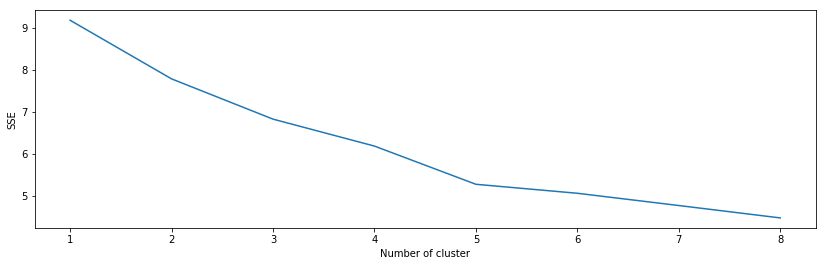

In [274]:
queens_venues_clustering = queens_grouped.drop('Neighborhood', 1)
sse = {}
for k in range(1,9):
    kmeans = KMeans(n_clusters=k).fit(queens_venues_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(14,4))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### let's run k-means to cluster the neighborhood into 5 clusters

In [275]:
# set number of clusters
kclusters = 5

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_#[0:10]

array([0, 3, 0, 0, 0, 3, 4, 0, 3, 1, 0, 0, 1, 0, 0, 2, 3, 0, 3, 3, 0, 0,
       3, 0, 3, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 3,
       0, 0, 3, 0, 0, 0, 0, 3, 1, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3,
       0, 0, 1, 4, 0, 0, 0, 3, 0, 3, 3, 0, 1, 0, 3], dtype=int32)

### let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [276]:
# add clustering labels
queens_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(queens_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,3,Restaurant,Bar,Hookah Bar,Bakery,Pub,Ice Cream Shop,Food Truck,Coffee Shop,Bubble Tea Shop,Salon / Barbershop
1,Queens,Woodside,40.746349,-73.901842,3,Restaurant,Grocery Store,Pub,Bakery,Pizza Place,Donut Shop,Bar,Ice Cream Shop,Deli / Bodega,Café
2,Queens,Jackson Heights,40.751981,-73.882821,3,Restaurant,Mobile Phone Shop,Bakery,Diner,Pharmacy,Supermarket,Supplement Shop,Kids Store,Shoe Store,Donut Shop
3,Queens,Elmhurst,40.744049,-73.881656,3,Restaurant,Bubble Tea Shop,Ice Cream Shop,Gym / Fitness Center,Salon / Barbershop,Snack Place,Bar,Bank,Food,Gymnastics Gym
4,Queens,Howard Beach,40.654225,-73.838138,3,Restaurant,Pharmacy,Bagel Shop,Sandwich Place,Spa,Fried Chicken Joint,Donut Shop,Diner,Deli / Bodega,Cosmetics Shop


### let's visualize the resulting clusters

In [277]:
# geographical coordinate for Queens
address = 'Queens, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], 
                                  queens_merged['Longitude'], 
                                  queens_merged['Neighborhood'], 
                                  queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Queens are 40.6524927, -73.7914214158161.


### let's find popular categories for each cluster

In [480]:
for k in range(kclusters):
    # instantiate the dataframe
    cluster_result = pd.DataFrame(columns=['Venue Category'])
    cluster = queens_merged.loc[queens_merged['Cluster Labels'] == k, 
                  queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
    
    print('Cluster : ' + str(k))
    
    for i in range(cluster.shape[0]):
        for j in range(cluster.shape[1]):
            cluster_result = cluster_result.append({'Venue Category': cluster.iloc[i][j]}, ignore_index=True)
            
    print(cluster_result.mode().values)
    print()

Cluster : 0
[['Restaurant']]

Cluster : 1
[['Beach']
 ['Deli / Bodega']
 ['Fish & Chips Shop']]

Cluster : 2
[['Brookville']
 ['Deli / Bodega']
 ['Donut Shop']
 ['Eye Doctor']
 ['Farm']
 ['Farmers Market']
 ['Fish & Chips Shop']
 ['Fish Market']
 ['Flea Market']
 ['Flower Shop']
 ['Yoga Studio']]

Cluster : 3
[['Restaurant']]

Cluster : 4
[['Event Space']
 ['Eye Doctor']
 ['Farm']
 ['Farmers Market']
 ['Fish & Chips Shop']
 ['Fish Market']
 ['Park']
 ['Yoga Studio']]



## it seems cluster 0 and 3 has got some popular restaurants